<a href="https://colab.research.google.com/github/Rango-Zhang-Hang/AI6103-DEEP-LEARNING-APPLICATIONS/blob/main/Assignment2DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import torch
#from transformers import *
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM
from transformers import AdamW, BertTokenizer, get_linear_schedule_with_warmup


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [11]:
from google.colab import files,drive
drive.mount('/content/drive/')
df2 = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')
df2

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
51569,I thought this movie did a down right good job...,positive
51570,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
51571,I am a Catholic taught in parochial elementary...,negative
51572,I'm going to have to disagree with the previou...,negative


In [12]:
df2['sentiment'] = df2['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df2.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Data Analysis

In [13]:
#dataset dimensions
df2.shape

(51574, 2)

In [14]:
df2.columns

Index(['review', 'sentiment'], dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'sentiments')

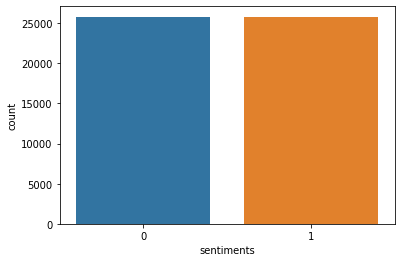

In [15]:
#Labeled review barplot
sns.countplot(df2.sentiment)
plt.xlabel('sentiments')

In [16]:
df2.isnull().sum()

review       0
sentiment    0
dtype: int64

In [17]:
# Number of poitive and negative reviews
df2.sentiment.value_counts()

0    25819
1    25755
Name: sentiment, dtype: int64

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51574 entries, 0 to 51573
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     51574 non-null  object
 1   sentiment  51574 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 806.0+ KB


In [19]:
df2

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
51569,I thought this movie did a down right good job...,1
51570,"Bad plot, bad dialogue, bad acting, idiotic di...",0
51571,I am a Catholic taught in parochial elementary...,0
51572,I'm going to have to disagree with the previou...,0


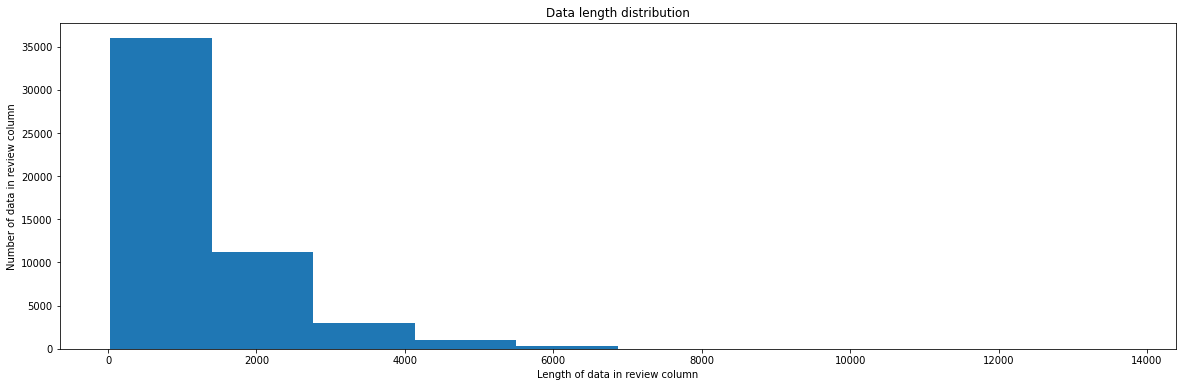

In [20]:
# Average number of words in review  
plt.figure(figsize=(20, 6))
plt.hist([len(n) for n in list(df2['review'])])
plt.xlabel('Length of data in review column')
plt.ylabel('Number of data in review column')
plt.title('Data length distribution')
plt.show()

Cleansing of Data

In [21]:
import tensorflow as tf
import re

def cleansingtext(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    text=re.sub("\s\s+" , " ", text)
    text=text.lower()
    text= re.sub('<.*?##>', ' ', text)
    text= re.sub('\[[^]].()*\]', '', text)
    return text

def preprocess_review(text):
    clean_text = cleansingtext(text)
    return clean_text


In [22]:
df2["review"] = df2.review.apply(preprocess_review)


In [23]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [24]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME , return_dict=False)

In [25]:
#Let's see how Bertencoder is encoding a sentence
text = 'This a fantastic movie of three prisoners who become famous. One of the actors is george clooney \
and I am not a fan but this roll is not bad Another good thing about the movie is the soundtrack The man of constant sorrow I recommand this movie to everybody. Greetings Bart'

tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: This a fantastic movie of three prisoners who become famous. One of the actors is george clooney and I am not a fan but this roll is not bad Another good thing about the movie is the soundtrack The man of constant sorrow I recommand this movie to everybody. Greetings Bart
   Tokens: ['This', 'a', 'fantastic', 'movie', 'of', 'three', 'prisoners', 'who', 'become', 'famous', '.', 'One', 'of', 'the', 'actors', 'is', 'g', '##eor', '##ge', 'c', '##lo', '##oney', 'and', 'I', 'am', 'not', 'a', 'fan', 'but', 'this', 'roll', 'is', 'not', 'bad', 'Another', 'good', 'thing', 'about', 'the', 'movie', 'is', 'the', 'soundtrack', 'The', 'man', 'of', 'constant', 'sorrow', 'I', 're', '##com', '##mand', 'this', 'movie', 'to', 'everybody', '.', 'G', '##reet', '##ings', 'Bart']
Token IDs: [1188, 170, 14820, 2523, 1104, 1210, 5419, 1150, 1561, 2505, 119, 1448, 1104, 1103, 5681, 1110, 176, 25690, 2176, 172, 2858, 18066, 1105, 146, 1821, 1136, 170, 5442, 1133, 1142, 5155, 1110, 1136, 2213, 2543, 136

In [26]:
#Performing preprocessing 
encoding = tokenizer.encode_plus(
  text,
  max_length=32,
  add_special_tokens=True, 
  return_token_type_ids=False,
  pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [27]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

63


tensor([  101,  1188,   170, 14820,  2523,  1104,  1210,  5419,  1150,  1561,
         2505,   119,  1448,  1104,  1103,  5681,  1110,   176, 25690,  2176,
          172,  2858, 18066,  1105,   146,  1821,  1136,   170,  5442,  1133,
         1142,  5155,  1110,  1136,  2213,  2543,  1363,  1645,  1164,  1103,
         2523,  1110,  1103,  5945,  1109,  1299,  1104,  4836, 17359,   146,
         1231,  8178, 20993,  1142,  2523,  1106, 10565,   119,   144, 17399,
         5018, 13045,   102])

In [28]:
#Attentions masked 
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

63


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [29]:
#Tokenized with BERT tokenizer
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'This',
 'a',
 'fantastic',
 'movie',
 'of',
 'three',
 'prisoners',
 'who',
 'become',
 'famous',
 '.',
 'One',
 'of',
 'the',
 'actors',
 'is',
 'g',
 '##eor',
 '##ge',
 'c',
 '##lo',
 '##oney',
 'and',
 'I',
 'am',
 'not',
 'a',
 'fan',
 'but',
 'this',
 'roll',
 'is',
 'not',
 'bad',
 'Another',
 'good',
 'thing',
 'about',
 'the',
 'movie',
 'is',
 'the',
 'soundtrack',
 'The',
 'man',
 'of',
 'constant',
 'sorrow',
 'I',
 're',
 '##com',
 '##mand',
 'this',
 'movie',
 'to',
 'everybody',
 '.',
 'G',
 '##reet',
 '##ings',
 'Bart',
 '[SEP]']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

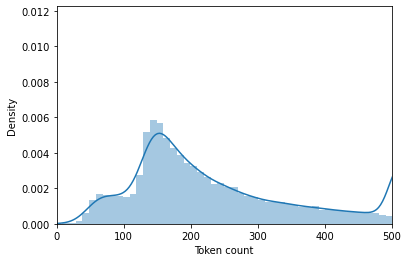

In [30]:
token_lens = []

for txt in df2.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


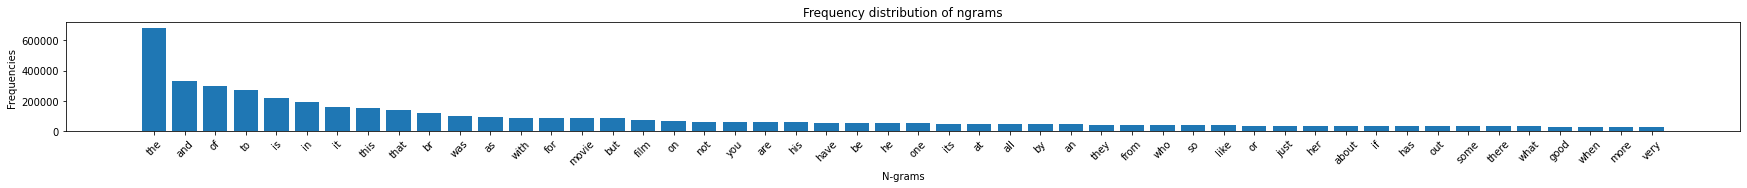

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] ('the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'or', 'just', 'her', 'about', 'if', 'has', 'out', 'some', 'there', 'what', 'good', 'when', 'more', 'very')


In [31]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(df2['review']))
# ['word1', 'word2', 'word3', 'word4']
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 2))
plt.bar(idx, counts)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

print(idx, ngrams)




In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
ngram = (1, 2)
TOPlist = 10000
Min_Freq= 2

def ngram_function(texts, labels):
    kwargs = {
        'ngram_range' : ngram,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : 'word',
        'min_df' : Min_Freq,
    }
    #  Train data and vectorize train and val sets
    tfidf = TfidfVectorizer(**kwargs)
    texts = tfidf.fit_transform(texts)
    
    # Feature importance derived by f_classif to determine the best k-features
    result = SelectKBest(f_classif, k=min(TOPlist, texts.shape[1]))
    result.fit(texts, labels)
    texts = result.transform(texts).astype('float32')
    return texts
# Vectorize the data
vectordata = ngram_function(df2['review'], df2['sentiment'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:2032: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning,


In [33]:
vectordata.shape

(51574, 10000)

In [34]:
tfidf = TfidfVectorizer()
result_texts = tfidf.fit_transform(df2['review'])
result_texts.shape

(51574, 180746)

Split the Data 

In [35]:
MAX_LEN = 200      #for not consuming much resources
RANDOM_SEED = 42
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [36]:
#doing the split of the dataset into training, validation and testing sets
df_train, df_test = train_test_split(df2, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape

(46416, 2)

In [37]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }


In [38]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [39]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [40]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [50]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['sentiments'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


Reviews Classification with BERT and Hugging Face¶


In [51]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [52]:
class IMDBClassifier(nn.Module):

  def __init__(self, n_classes):
    super(IMDBClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME , return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)
    

In [53]:
model = IMDBClassifier(len(df2['sentiment'].unique()))
model = model.to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


In [55]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5178, 0.4822],
        [0.5880, 0.4120],
        [0.3601, 0.6399],
        [0.5402, 0.4598],
        [0.6044, 0.3956],
        [0.6171, 0.3829],
        [0.4776, 0.5224],
        [0.6688, 0.3312],
        [0.5268, 0.4732],
        [0.6419, 0.3581],
        [0.4946, 0.5054],
        [0.5596, 0.4404],
        [0.7257, 0.2743],
        [0.6374, 0.3626],
        [0.6603, 0.3397],
        [0.5287, 0.4713]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Training (fine-tuning of BERT for classification task)¶

In [56]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [57]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
EPOCHS = 10
#net = IMDBClassifier().to('cuda')
loss_fn = nn.CrossEntropyLoss().to('cuda')
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

train_acc = []
train_loss = []
val_acc = []
val_loss = []
best_accuracy = 0

for epoch in range(1,11):

  #print(f'Epoch {epoch + 1}')
  #print('-' * 10)
  train_acc_, train_loss_ = train_epoch(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss_} accuracy {train_acc_}')
  val_acc_, val_loss_ = eval_model(model,val_data_loader,loss_fn, device, len(df_val))
  print(f'Val   loss {val_loss_} accuracy {val_acc_}')
  #print()
  print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

KeyboardInterrupt: ignored

## Implementation of Early Stopping

In [59]:
!sudo pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
##Import Library
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
import skimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
#from tensorflow.python.keras.engine.sequential import Sequential
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import keras
import keras.utils
from keras import utils as np_utils


## As based on the Early Stopping, this is used when the not able to determine which hyperparameter to use , therefore the split will be resplit with Training , Testing and Validation dataset 


In [109]:
from sklearn.model_selection import train_test_split

random_state =42
# Split data to y and X
# x = feature 
# y = targets
X = vectordata.toarray()
y = (np.array(df2['sentiment']))


# Here we split data to training and testing parts
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
#print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))


# set aside 10% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.1, shuffle = True, random_state = 42)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.2, random_state= 42) 


print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))


X_train shape: (37132, 10000)
X_test shape: (5158, 10000)
y_train shape: (37132,)
y_test shape: (5158,)
X_val shape: (37132,)
y val shape: (5158,)


In [110]:
 #First, let's create a function that returns the appropriate number of units and the activation for the last layer.
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'relu'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [111]:
input_shape = df_val.shape[1:]
input_shape

(2,)

In [144]:
import tensorflow as tf
from tensorflow import keras


# input shape is the vocabulary count used for the movie reviews (10,000 words)
DROPOUT_RATE = 0.5
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = df_val.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = keras.Sequential()
# Applies Dropout to the input
#model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='relu'))
   # model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.build(input_shape=(2,10000))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_16 (ModuleWr  (2, 64)                  640064    
 apper)                                                          
                                                                 
 module_wrapper_17 (ModuleWr  (2, 1)                   65        
 apper)                                                          
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


In [69]:
 ## Import to use AdamW under tensorflow
 !pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
import tensorflow_addons as tfa


In [71]:
## Under Kera there is AdamW opimiser 
!pip install keras-adamw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Complie the model

In [145]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow_addons.optimizers import AdamW
learning_rate = 2e-5

loss = 'binary_crossentropy'
optimizer = tfa.optimizers.AdamW(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
epoch_no =10 # Follow the baseline set up 

In [114]:
##Baseline Set up (Need to be similar or +0.01/-0.01 with the baseline)
history0 = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE)

Epoch 1/10
2321/2321 [==============================] - 8s 3ms/step - loss: 0.3559 - acc: 0.8770 - val_loss: 0.2816 - val_acc: 0.9168
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.2395 - acc: 0.9332 - val_loss: 0.3225 - val_acc: 0.9180
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.2041 - acc: 0.9481 - val_loss: 0.3633 - val_acc: 0.9211
Epoch 4/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1861 - acc: 0.9581 - val_loss: 0.4535 - val_acc: 0.9174
Epoch 5/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1652 - acc: 0.9667 - val_loss: 0.5052 - val_acc: 0.9153
Epoch 6/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1446 - acc: 0.9764 - val_loss: 0.6194 - val_acc: 0.9159
Epoch 7/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1289 - acc: 0.9850 - val_loss: 0.7081 - val_acc: 0.9128
Epoch 8/10
2321/2321 [==============================] - 7s 3ms

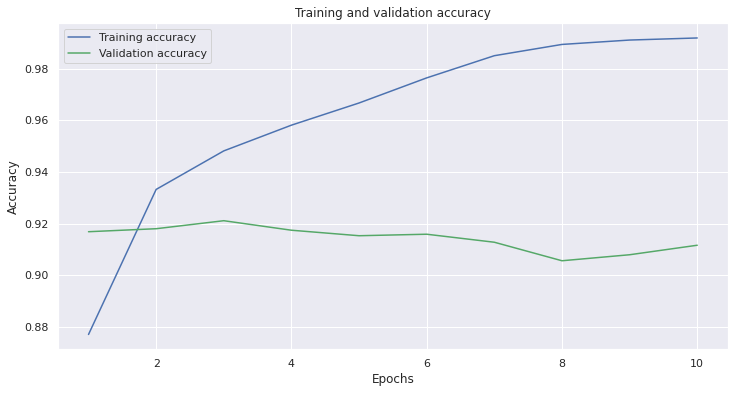

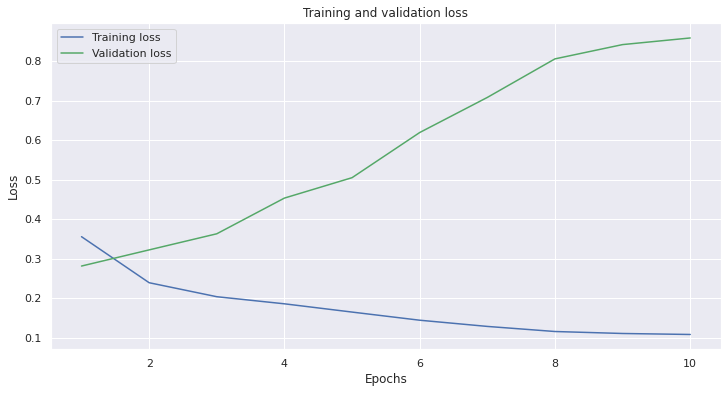

In [115]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history0):
    accuracy = history0.history['acc']
    val_accuracy = history0.history['val_acc']
    loss = history0.history['loss']
    val_loss = history0.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history0)

In [146]:
# Create callback for early stopping on validation loss.
## Patience = 2 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0, mode ='auto',verbose =1)]

# Train and validate model -val_loss
history = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE,callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 8s 3ms/step - loss: 0.3366 - acc: 0.8881 - val_loss: 0.2759 - val_acc: 0.9112
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.2325 - acc: 0.9352 - val_loss: 0.3059 - val_acc: 0.9201
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.2042 - acc: 0.9488 - val_loss: 0.3535 - val_acc: 0.9145
Epoch 3: early stopping


In [138]:
# Create callback for early stopping on validation loss.
## Patience = 2 and Min Delta = 0.01
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01, mode ='auto',verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1917 - acc: 0.9553 - val_loss: 0.6030 - val_acc: 0.8938
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1770 - acc: 0.9611 - val_loss: 0.4636 - val_acc: 0.9162
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1584 - acc: 0.9712 - val_loss: 0.5472 - val_acc: 0.9159
Epoch 4/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1436 - acc: 0.9784 - val_loss: 0.6482 - val_acc: 0.9087
Epoch 4: early stopping


In [139]:
# Create callback for early stopping on validation loss.
## Patience = 2 and Min Delta = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001, mode ='auto',verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1345 - acc: 0.9838 - val_loss: 0.7010 - val_acc: 0.9102
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1206 - acc: 0.9885 - val_loss: 0.7180 - val_acc: 0.9083
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1164 - acc: 0.9903 - val_loss: 0.7765 - val_acc: 0.9056
Epoch 3: early stopping


In [119]:
#create callback for early stopping on validation loss. If the loss does
## Patience = 1 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=0, mode ='auto', verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0999 - acc: 0.9929 - val_loss: 0.8999 - val_acc: 0.9064
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0984 - acc: 0.9931 - val_loss: 0.8211 - val_acc: 0.9098
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1006 - acc: 0.9928 - val_loss: 0.8698 - val_acc: 0.9048
Epoch 3: early stopping


In [122]:
#create callback for early stopping on validation loss. If the loss does
## Patience = 1 and Min Delta = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001, mode ='auto', verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0975 - acc: 0.9931 - val_loss: 0.9136 - val_acc: 0.9066
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0979 - acc: 0.9931 - val_loss: 0.8550 - val_acc: 0.9081
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0971 - acc: 0.9933 - val_loss: 0.8795 - val_acc: 0.9071
Epoch 3: early stopping


In [123]:
#create callback for early stopping on validation loss. If the loss does
## Patience = 0 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, min_delta=0, mode ='auto', verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0976 - acc: 0.9930 - val_loss: 0.8582 - val_acc: 0.9062
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0965 - acc: 0.9932 - val_loss: 0.8507 - val_acc: 0.9069
Epoch 2: early stopping


In [124]:
from tensorflow.keras.callbacks import ModelCheckpoint 

## Patience = 0 and Min Delta = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, min_delta=0.0001, mode ='auto',verbose = 1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0957 - acc: 0.9934 - val_loss: 0.8180 - val_acc: 0.9069
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.0956 - acc: 0.9934 - val_loss: 0.8335 - val_acc: 0.9052
Epoch 2: early stopping


In [140]:
import tensorflow as tf
from tensorflow import keras


# input shape is the vocabulary count used for the movie reviews (10,000 words)
#DROPOUT_RATE = 0.2
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = df_val.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = keras.Sequential()
# Applies Dropout to the input
#model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='sigmoid'))
   # model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.build(input_shape=(2,10000))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_14 (ModuleWr  (2, 64)                  640064    
 apper)                                                          
                                                                 
 module_wrapper_15 (ModuleWr  (2, 1)                   65        
 apper)                                                          
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


In [141]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow_addons.optimizers import AdamW
learning_rate = 2e-5

loss = 'binary_crossentropy'
optimizer = tfa.optimizers.AdamW(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
epoch_no =10 # Follow the baseline set up 

In [143]:
from tensorflow.keras.callbacks import ModelCheckpoint 

## Patience = 2 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0, mode ='auto',verbose = 1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 7.6664 - acc: 0.5030 - val_loss: 7.6945 - val_acc: 0.5012
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 7.6664 - acc: 0.5030 - val_loss: 7.6945 - val_acc: 0.5012
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 7.6664 - acc: 0.5030 - val_loss: 7.6945 - val_acc: 0.5012
Epoch 3: early stopping


In [ ]:
results = model.evaluate(X_test,  y_test, verbose = 1)
print('test loss, test acc:', results)

In [ ]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)